#Xenon-135 Bateman Equation Solver with Off-Gas Stripping

This script is used to simulate the Xenon-Iodine system of equations that
dominates the fission product neutron poison concentration in a nuclear reactor.

This is an object oriented script, allowing each method under class-Nuclide to operate on the nuclides in the decay chain (namely Xe135 and I135). The methods in this class represent each term of the system of DiffEQs. The timestep method calls each previous method to calculate the change in concentration based off of each term (generation or consumption), then applies arithmetic to calculate the total time-rate-of-change

In [1]:
%reset -f

###Importing the necessary packages

numpy for arrays

pyplot for plotting

tqdm for progress bars

In [2]:

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

##Set Up the framework for the simulation

###Define a global class that defines the constants needed to describe the core as well as gives the ability (through class methods) to modify conditions, e.g. simulate a scram or power transient

In [3]:
class Core: #Defining constants and allowing parameter changing (e.g. scram or power transient)
    #Constants
    chi = 0.5 #downcomer split fraction -- unused as ddt_strip is split fraction independent
    tau = 130 #sec // flow period of molten salt
    sigma_F = 1e-24*np.array([2.53821289e+03,
                               3.68718323e+02,
                               3.69831489e+01,
                               2.67799814e+00,
                               1.23098738e+00]) #cm-2 slow/epithermal/resonance/fast/ultrafast
    gamma = {'I':0.0639,'Xe':0.00237} #dictionaries are used to assign constants to instances of class Nuclide
    lamda = {'I':2.87e-5, 'Xe':2.09e-5} #sec^-1
    sigma = {'I':0,
             'Xe':1e-24*np.array([4.79361371e+06,
                                  7.49446956e+05, 
                                  4.51014736e+04, 
                                  9.06774603e-02, 
                                  2.40673564e-03])} #cm^2 `slow/epithermal/resonance/fast/ultrafast`
    H = {'I':None,'Xe':1e-4} #c_g/c_l

    #FUEL... 18mol% HALEU-UF4 in FLiNaK @ 19.75% enrichment
    mole = 0.18
    enrichment = 0.1975 
    Avo = 6.0221408e23
    mass_den = 3.60510 #g/cm3 @915K
    MW = 35.555
    N = Avo*mass_den/MW #atoms/cm3
    basis = 5*mole+2*(1-mole)
    molefrac235 = mole/basis*enrichment
    Sigma_F = sigma_F*N*molefrac235 #cm-1
    #Parameters (initial)
    flux = 30*np.array([3.89705195e+07,
                    2.12840508e+11,
                    1.25184031e+13,
                    8.53134220e+13,
                    6.90082000e+12]) #n/cm2/s slow/epithermal/resonance/fast/ultrafast
    FissionRate = Sigma_F*flux #cm-3.s
    print(f'Fission Rate: {FissionRate} cm-3.s')
    PowerDensity = FissionRate*200 #MeV/cm3.s
    Volume = 4.29116E5 #cm3
    Power = PowerDensity*Volume*1.6022e-13 #W
    print(f'{np.sum(Power*1e-6)} MegaWatts')
    
    phi = flux
    Vdot_ratio = 0
    check = False

    #Parameters (after scram)
    @classmethod
    def scram(cls,strip):
        cls.phi= np.zeros(cls.phi.size) #n/cm2/s
        cls.check = True
        cls.eqXe = Xenon.concentration[-1]
        cls.Vdot_ratio = strip

    @classmethod #This is a method used to place the vertical dashed line in the post scram plot
    def cross(cls):
        cls.check = False
    
    @classmethod
    def restart(cls):
        cls.phi = cls.flux

Fission Rate: [2.53605648e+09 2.01207279e+12 1.18699120e+13 5.85763511e+12
 2.17795540e+11] cm-3.s
274.4611714546206 MegaWatts


###Define a class that serves as the framework for creating nuclide objects

In [4]:
class Nuclide: #used to create iodine and xenon objects
    nuclides=[]
    def __init__(self, element,daughter):
        #dunder-init creates an instance of the Nuclide Class and assigns it initial properties.
        #A dictionary was used to assign these values conviniently but they could be assigned as arguments
        self.gamma, self.lamda, self.sigma, self.H = Core.gamma[element], Core.lamda[element], Core.sigma[element], Core.H[element]
        self.daughter = daughter
        self.concentration = [0] #atoms/cm3
        self.fission=[0] #atoms/cm3.s
        self.beta=[0] #atoms/cm3.s
        self.capture=[0] #atoms/cm3.s
        self.precursor=[0] #atoms/cm3.s
        self.strip=[0]
        Nuclide.nuclides.append(self)

    def ddt_fission(self): #generation term directly from fission
        ddt_multigroup = self.gamma*Core.Sigma_F*Core.phi
        ddt = np.sum(ddt_multigroup)
        self.fission.append(ddt)
        return ddt

    def ddt_beta(self): #consumption term by beta decay -- generation term for beta daughter
        ddt = self.lamda*self.concentration[-1]
        self.beta.append(ddt)
        if self.daughter != None:
            self.daughter.precursor.append(ddt)
        return ddt

    def ddt_capture(self): #consumption term. atom species changed by radiative capture
        ddt_5group = self.concentration[-1]*self.sigma*Core.phi
        ddt = np.sum(ddt_5group)
        self.capture.append(ddt)
        return ddt

    def ddt_strip(self): #novel - my derivation of a ddt term for single stage equilibrim stripping
        try: #calculates nuclide concentration term when valid
            ddt = self.concentration[-1]/Core.tau/(self.H/Core.Vdot_ratio+1)
        except (ZeroDivisionError, TypeError): #excludes stripping for Iodine and when helium flow rate is zero for Xenon
            ddt = 0
        self.strip.append(ddt)
        return ddt

    def timestep(self): #calls each term specific method then sums them and appends it to the object.concentration array
        self.ddt_fission()
        self.ddt_beta()
        self.ddt_capture()
        self.ddt_strip()
        ddt = self.fission[-1]+self.precursor[-1]-self.beta[-1]-self.capture[-1]-self.strip[-1]
        new = self.concentration[-1] + ddt
        self.concentration.append(new)
        return ddt
    
    @classmethod
    def numpy(cls): #converts the concentration lists to numpy arrays for ease of plotting
        for nuclide in cls.nuclides:
            nuclide.concentration = N2C(np.array(nuclide.concentration))
            
    @classmethod
    def reset(cls):
        for nuclide in cls.nuclides:
            nuclide.concentration = [0] #atoms/cm3
            nuclide.fission=[0] #atoms/cm3.s
            nuclide.beta=[0] #atoms/cm3.s
            nuclide.capture=[0] #atoms/cm3.s
            nuclide.precursor=[0] #atoms/cm3.s
            nuclide.strip=[0]

###Define function that converts from number density (atoms/cm3) to molar concentration (millimol/m3)

In [5]:
def N2C(Ni):
    Ci = 1e6*Ni/(Core.Avo/1000)
    return Ci

##Run the Simulation

###Instantiate Nuclide Objects

This is done as a void function so that later cells can re-instantiate as needed

In [6]:
Xenon = Nuclide('Xe',None)
Iodine = Nuclide('I',Xenon)


###Calculate expected equilibrium concentrations

In [7]:
infI = Iodine.gamma*np.sum(Core.FissionRate)/Iodine.lamda
infXe = (Iodine.gamma+Xenon.gamma)*np.sum(Core.FissionRate)/(Xenon.lamda+np.sum(Xenon.sigma*Core.phi))

print(f'Equilibrium Concentrations')
print(f'{N2C(infI)} millimol/m3 I-135')
print(f'{N2C(infXe)} millimol/m3 Xe-135')

print(f'Initial Scram Rates')
print(f'{N2C(-infI*Iodine.lamda)} millimol/m3-s I-135')
print(f'{N2C(infI*Iodine.lamda-infXe*Xenon.lamda)} millimol/m3-s Xe-135')

Equilibrium Concentrations
73.79510207961415 millimol/m3 I-135
51.52507968817015 millimol/m3 Xe-135
Initial Scram Rates
-0.002117919429684926 millimol/m3-s I-135
0.0010410452642021701 millimol/m3-s Xe-135


Loop Parameters

In [8]:
dt=1 #sec
begin = 0 #hours
scram = 200 #hours
end = 300 #hours
time = np.arange(begin,end*3600+1,dt) #sec

###Simulate without stripper

In [9]:
Core.restart()
Nuclide.reset()
for t in tqdm(time):
    Iodine.timestep()
    Xenon.timestep()

    if t==scram*3600:
        Core.scram(0)

    if Core.check and Xenon.concentration[-1] < Core.eqXe:
        Core.cross()
        eqt=t
        
#convert to numpy arrays for ease of plotting
Nuclide.numpy()
Core.eqXe = N2C(Core.eqXe)


100%|██████████| 1080001/1080001 [00:30<00:00, 35419.51it/s]


###Plot Rise to Equilibrium

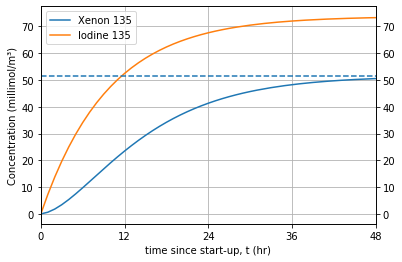

In [10]:
ax =  plt.gca()
plt.xlabel('time since start-up, t (hr)')
plt.ylabel(f'Concentration (millimol/m\N{SUPERSCRIPT THREE})')
plt.xlim(0,48)
plt.xticks([0,12,24,36,48])
plt.plot(time[::3600]/3600,Xenon.concentration[::3600],label='Xenon 135')
plt.plot(time[::3600]/3600,Iodine.concentration[::3600],label='Iodine 135')
plt.axhline(Core.eqXe,linestyle='--')
plt.grid()
plt.legend(loc='best')
twin_ax = ax.twinx()
twin_ax.set_ylim(ax.get_ylim())

plt.show()

###Plot After Scram

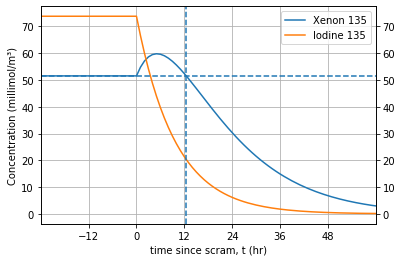

In [11]:
ax =  plt.gca()
plt.xlabel('time since scram, t (hr)')
plt.ylabel(f'Concentration (millimol/m\N{SUPERSCRIPT THREE})')
plt.xlim(-24,60)
plt.xticks([-12,0,12,24,36,48])
plt.plot(time[::3600]/3600-scram,Xenon.concentration[::3600],label='Xenon 135')
plt.plot(time[::3600]/3600-scram,Iodine.concentration[::3600],label='Iodine 135')
plt.axhline(Core.eqXe,linestyle='--')
plt.axvline(eqt/3600-scram,linestyle='--')
plt.grid()
plt.legend(loc='best')
twin_ax = ax.twinx()
twin_ax.set_ylim(ax.get_ylim())

plt.show()

###Simulate with Stripper

In [255]:
Core.restart()
Nuclide.reset()
for t in tqdm(time):
    Iodine.timestep()
    Xenon.timestep()

    if t==scram*3600:
        Core.scram(1.1e-6)

    if Core.check and Xenon.concentration[-1] < Core.eqXe:
        Core.cross()
        eqt=t
        
#convert to numpy arrays for ease of plotting
Nuclide.numpy()
Core.eqXe = N2C(Core.eqXe)

100%|██████████| 1080001/1080001 [00:44<00:00, 24461.76it/s]


###Plot after Scram with Stripper

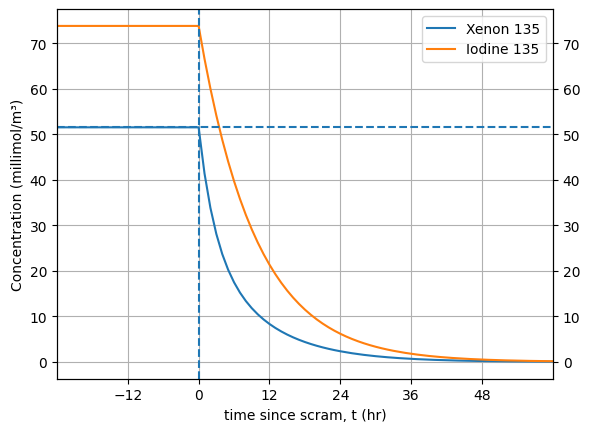

In [256]:
ax =  plt.gca()
plt.xlabel('time since scram, t (hr)')
plt.ylabel(f'Concentration (millimol/m\N{SUPERSCRIPT THREE})')
plt.xlim(-24,60)
plt.xticks([-12,0,12,24,36,48])
plt.plot(time[::3600]/3600-scram,Xenon.concentration[::3600],label='Xenon 135')
plt.plot(time[::3600]/3600-scram,Iodine.concentration[::3600],label='Iodine 135')
plt.axhline(Core.eqXe,linestyle='--')
plt.axvline(eqt/3600-scram,linestyle='--')
plt.grid()
plt.legend(loc='best')
twin_ax = ax.twinx()
twin_ax.set_ylim(ax.get_ylim())

plt.show()